# Beehive Sensor Data Anylsis
- Processing the raw bee date to a clean data set for furhter consumption

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from hampel import hampel

Load Data

In [2]:
data = pd.read_csv(".streamlit/24-09-21_beehive.csv")
print(data.dtypes)
data

created_at     object
entry_id        int64
field1         object
field2        float64
field3         object
latitude      float64
longitude     float64
elevation     float64
status        float64
dtype: object


C:\Users\timwy\AppData\Local\Temp\ipykernel_8460\4258313334.py:1: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(".streamlit/24-09-21_beehive.csv")


,created_at,entry_id,field1,field2,field3,latitude,longitude,elevation,status
0,2020-10-14T17:03:37+02:00,1,49.63,78.0,13.1,NaN,NaN,NaN,NaN
1,2020-10-14T17:13:41+02:00,2,49.77,95.0,20.3,NaN,NaN,NaN,NaN
2,2020-10-14T17:23:45+02:00,3,49.79,95.0,23.1,NaN,NaN,NaN,NaN
3,2020-10-14T17:33:49+02:00,4,49.78,86.0,23.4,NaN,NaN,NaN,NaN
4,2020-10-14T17:43:53+02:00,5,49.77,79.0,23.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
174004,2024-10-06T19:13:26+02:00,174005,42.54,80.0,21.50,NaN,NaN,NaN,NaN
174005,2024-10-06T19:23:27+02:00,174006,42.53,80.0,21.50,NaN,NaN,NaN,NaN
174006,2024-10-06T19:33:28+02:00,174007,42.65,80.0,21.40,NaN,NaN,NaN,NaN
174007,2024-10-06T19:43:30+02:00,174008,42.38,80.0,21.50,NaN,NaN,NaN,NaN


## Preprocessing

In [3]:
columns_to_drop =["latitude", "longitude", "elevation", "status"] # List of column names to drop
data.drop(columns=columns_to_drop, inplace=True)

# Rename columns
data.rename(columns={'field1': 'weight', 'field3': 'temperature', 'field2': 'humidity'}, inplace=True)

In [4]:
#CASTING
# Convert string column to datetime
data['created_at'] = pd.to_datetime(data['created_at'], format='%Y-%m-%dT%H:%M:%S%z', errors='coerce', utc=True)
print(data[data['created_at'].isna()])
data = data[pd.to_numeric(data['temperature'], errors='coerce').notnull()]
data['humidity'] = data['humidity'].astype(float)

# Extract the year and create a new column
data['year'] = data['created_at'].dt.year
data['month'] = data['created_at'].dt.month
data['day'] = data['created_at'].dt.day
# Concatenate 'month' and 'day' into a single column
data['month_day'] = data['created_at'].dt.strftime('%m-%d')

# Remove rows where 'weight' is equal to "~"
data = data[data['weight'] != "~"]
# Convert 'weight' column to float
data.loc[:, 'weight'] = data['weight'].astype(float)
data = data[data['weight'] >= 0]



Empty DataFrame
Columns: [created_at, entry_id, weight, humidity, temperature]
Index: []


C:\Users\timwy\AppData\Local\Temp\ipykernel_8460\2000069269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['humidity'] = data['humidity'].astype(float)
C:\Users\timwy\AppData\Local\Temp\ipykernel_8460\2000069269.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['created_at'].dt.year
C:\Users\timwy\AppData\Local\Temp\ipykernel_8460\2000069269.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

## Hampel Filtering

In [5]:
data.set_index('created_at', inplace=True)
# Apply the Hampel filter
WINDOW_SIZE = 144 # 10 min/datapoint | 6 datapoint/hour | 144 datapoints/day
result = hampel(data['weight'], window_size=WINDOW_SIZE, n_sigma=3.0)

data_weight_filtered = result.filtered_data
outlier_indices = result.outlier_indices
medians = result.medians
mad_values = result.median_absolute_deviations
thresholds = result.thresholds
print(data_weight_filtered)



0         49.630001
1         49.770000
2         49.790001
3         49.779999
4         49.770000
            ...    
167389    42.540001
167390    42.529999
167391    42.650002
167392    42.380001
167393    42.389999
Length: 167394, dtype: float32


# Save Silver version (cleaned data set)

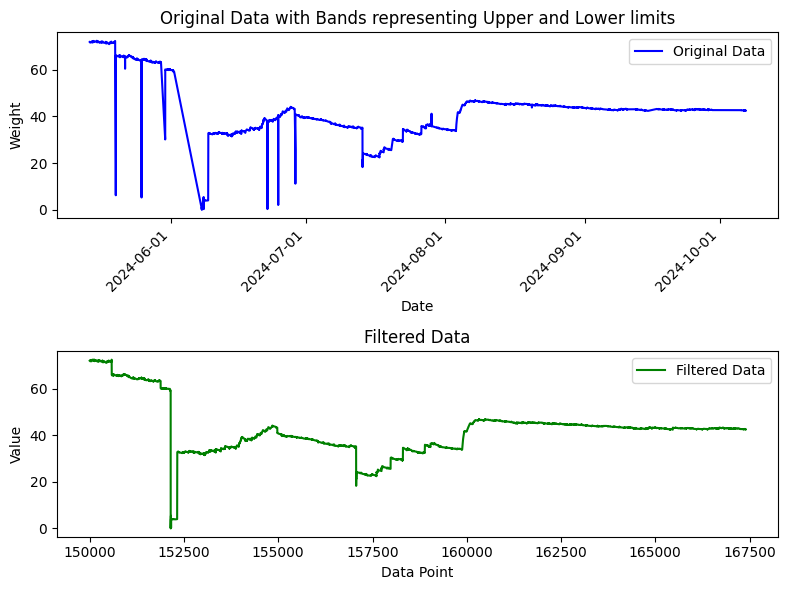

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
index_start = 150000

# Plot the original data with estimated standard deviations in the first subplot
axes[0].plot(data['weight'].iloc[index_start:], label='Original Data', color='b')

# Optionally fill the area between the bands (commented out in your code)
# axes[0].fill_between(data['date'].iloc[index_start:], medians + thresholds, medians - thresholds, color='gray', alpha=0.5, label='Median +- Threshold')

axes[0].set_xlabel('Date')
axes[0].set_ylabel('Weight')
axes[0].set_title('Original Data with Bands representing Upper and Lower limits')

# Format the x-axis to display dates nicely
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate the date labels for better readability
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

axes[0].legend()

# Plot the filtered data in the second subplot
axes[1].plot(data_weight_filtered.iloc[index_start:], label='Filtered Data', color='g')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('Value')
axes[1].set_title('Filtered Data')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

add filterd weight data back to original data set and change index

In [7]:
data_weight_filtered.index = data.index
data['weight_cleaned'] = data_weight_filtered

data = data.reset_index()
data


,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned
0,2020-10-14 15:03:37+00:00,1,49.63,78.0,13.1,2020,10,14,10-14,49.630001
1,2020-10-14 15:13:41+00:00,2,49.77,95.0,20.3,2020,10,14,10-14,49.770000
2,2020-10-14 15:23:45+00:00,3,49.79,95.0,23.1,2020,10,14,10-14,49.790001
3,2020-10-14 15:33:49+00:00,4,49.78,86.0,23.4,2020,10,14,10-14,49.779999
4,2020-10-14 15:43:53+00:00,5,49.77,79.0,23.5,2020,10,14,10-14,49.770000
...,...,...,...,...,...,...,...,...,...,...
167389,2024-10-06 17:13:26+00:00,174005,42.54,80.0,21.50,2024,10,6,10-06,42.540001
167390,2024-10-06 17:23:27+00:00,174006,42.53,80.0,21.50,2024,10,6,10-06,42.529999
167391,2024-10-06 17:33:28+00:00,174007,42.65,80.0,21.40,2024,10,6,10-06,42.650002
167392,2024-10-06 17:43:30+00:00,174008,42.38,80.0,21.50,2024,10,6,10-06,42.380001


In [8]:
# Saving the DataFrame to a CSV file
data.to_csv('.streamlit/24-09-21_beehive_cleaned.csv', index=False)